<a href="https://colab.research.google.com/github/bvkiran8058/Deep-Learning/blob/main/AQI_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline
tf.__version__

'2.18.0'

In [ ]:
air_index = pd.read_csv(r"Datasets\city_day.csv")
air_index.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
air_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


In [ ]:
air_index.isnull().sum()

City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

In [ ]:
air_index.corr(numeric_only= True)['AQI']

PM2.5      0.659181
PM10       0.803313
NO         0.452191
NO2        0.537071
NOx        0.486450
NH3        0.252019
CO         0.683346
SO2        0.490586
O3         0.198991
Benzene    0.044407
Toluene    0.279992
Xylene     0.165532
AQI        1.000000
Name: AQI, dtype: float64

In [ ]:
## Higly correlated columns with correlation greater than 2
columns_lessthan_point_two = []
columns_greaterthan_point_two = []
for column, value in dict(air_index.corr(numeric_only=True)['AQI']).items():
    if value > 0.2:
        columns_greaterthan_point_two.append(column)
    else:
        columns_lessthan_point_two.append(column)
columns_lessthan_point_two.append('Date') ## Added Date column to drop the Date column from the dataset
columns_greaterthan_point_two, columns_lessthan_point_two

(['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'Toluene', 'AQI'],
 ['O3', 'Benzene', 'Xylene', 'Date'])

In [ ]:
air_index_corr = air_index.drop(columns= columns_lessthan_point_two, axis=1)
air_index_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   PM2.5       24933 non-null  float64
 2   PM10        18391 non-null  float64
 3   NO          25949 non-null  float64
 4   NO2         25946 non-null  float64
 5   NOx         25346 non-null  float64
 6   NH3         19203 non-null  float64
 7   CO          27472 non-null  float64
 8   SO2         25677 non-null  float64
 9   Toluene     21490 non-null  float64
 10  AQI         24850 non-null  float64
 11  AQI_Bucket  24850 non-null  object 
dtypes: float64(10), object(2)
memory usage: 2.7+ MB


In [ ]:
## since NH3 has low correlation with AQI dropping NH3 might not be a problem
air_index_corr.drop(columns=['NH3'], axis=1, inplace= True)
## We need the rows where AQI is available
air_index_corr = air_index_corr.dropna(subset=['AQI'])
air_index_corr.isnull().sum()

City             0
PM2.5          678
PM10          7086
NO             387
NO2            391
NOx           1857
CO             445
SO2            605
Toluene       5826
AQI              0
AQI_Bucket       0
dtype: int64

#### Filling missing values for columns otherthan PM10 with mean or mode in both missing and train data

In [ ]:
columns_mean = ['PM2.5', 'NO', 'NO2', 'NOx', 'CO', 'SO2', 'Toluene']
for column in columns_mean:
    air_index_corr[column] = air_index_corr[column].fillna(air_index_corr[column].mean())
air_index_corr.isnull().sum()

City             0
PM2.5            0
PM10          7086
NO               0
NO2              0
NOx              0
CO               0
SO2              0
Toluene          0
AQI              0
AQI_Bucket       0
dtype: int64

#### Encoding City and AQI_Bucket columns

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in ['City', 'AQI_Bucket']:
    air_index_corr[column] = le.fit_transform(air_index_corr[column])
air_index_corr.head()

,City,PM2.5,PM10,NO,NO2,NOx,CO,SO2,Toluene,AQI,AQI_Bucket
28,0,83.13,NaN,6.93,28.71,33.72,6.93,49.52,0.00,209.0,2
29,0,79.84,NaN,13.85,28.68,41.08,13.85,48.49,0.00,328.0,5
30,0,94.52,NaN,24.39,32.66,52.61,24.39,67.39,0.01,514.0,4
31,0,135.99,NaN,43.48,42.08,84.57,43.48,75.23,0.04,782.0,4
32,0,178.33,NaN,54.56,35.31,72.80,54.56,55.04,0.06,914.0,4


### PM10 has high correlation with AQI dropping not the correct way
#### Building the model and fill the NAN values with predictions

In [ ]:
PM10_df_train = air_index_corr.dropna(subset=['PM10'])  # Rows where PM10 is available
PM10_df_missing = air_index_corr[air_index_corr['PM10'].isna()]  # Rows where PM10 is missing
PM10_df_train.shape, PM10_df_missing.shape

((17764, 11), (7086, 11))

In [ ]:
PM10_df_train.head()

,City,PM2.5,PM10,NO,NO2,NOx,CO,SO2,Toluene,AQI,AQI_Bucket
1595,0,37.55,122.41,15.08,85.12,58.72,15.08,163.01,85.54,281.0,2
1596,0,33.97,116.32,14.67,79.71,55.61,14.67,91.26,83.89,330.0,5
1597,0,35.48,130.07,18.02,77.61,58.41,18.02,98.35,83.83,356.0,5
1598,0,34.11,138.31,13.27,75.23,51.83,13.27,88.66,82.73,359.0,5
1599,0,33.69,111.73,34.56,68.90,69.77,34.56,80.90,84.17,547.0,4


In [ ]:
PM10_df_missing.head()

,City,PM2.5,PM10,NO,NO2,NOx,CO,SO2,Toluene,AQI,AQI_Bucket
28,0,83.13,NaN,6.93,28.71,33.72,6.93,49.52,0.00,209.0,2
29,0,79.84,NaN,13.85,28.68,41.08,13.85,48.49,0.00,328.0,5
30,0,94.52,NaN,24.39,32.66,52.61,24.39,67.39,0.01,514.0,4
31,0,135.99,NaN,43.48,42.08,84.57,43.48,75.23,0.04,782.0,4
32,0,178.33,NaN,54.56,35.31,72.80,54.56,55.04,0.06,914.0,4


#### Building a random forrest regression for predicting the PM10

In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_train = PM10_df_train.drop(columns=['PM10'])
y_train = PM10_df_train['PM10']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
X_missing = PM10_df_missing.drop(columns=['PM10'])
predicted_PM10 = model.predict(X_missing)

In [ ]:
air_index_corr.loc[air_index_corr['PM10'].isna(), 'PM10'] = predicted_PM10
air_index_corr.isnull().sum()

City          0
PM2.5         0
PM10          0
NO            0
NO2           0
NOx           0
CO            0
SO2           0
Toluene       0
AQI           0
AQI_Bucket    0
dtype: int64

In [ ]:
air_index_corr.corr()['AQI']

City         -0.123456
PM2.5         0.654740
PM10          0.701014
NO            0.450688
NO2           0.535274
NOx           0.474227
CO            0.678354
SO2           0.484822
Toluene       0.264428
AQI           1.000000
AQI_Bucket    0.451764
Name: AQI, dtype: float64

### Defining X, y variables

In [ ]:
X, y = air_index_corr.drop(columns= ['AQI'], axis=1), air_index_corr['AQI']
X.shape, y.shape

((24850, 10), (24850,))

### splitting and Normalizing the values between 0 and 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
min_scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_min_scaled = min_scaler.fit_transform(X_train)
X_test_min_scaled = min_scaler.transform(X_test)
X_train_min_scaled.shape, X_test_min_scaled.shape, y_train.shape, y_test.shape

((16649, 10), (8201, 10), (16649,), (8201,))

## Build the linear Regression model to predict AQI
1. Build the model using Sequential API
2. Compile the model with optimizer and loss
3. Fit the model with training data

In [ ]:
tf.random.set_seed(42)

## 1. Build the model
model1 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_min_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

## 2. Compile the model
model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss = tf.keras.losses.mae,
    metrics = ['mae']
)

## 3. Fit the model with training data
model1_history = model1.fit(X_train_min_scaled, y_train, epochs = 100, batch_size = 16)

Epoch 1/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 97.6338 - mae: 97.6338
Epoch 2/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 31.0844 - mae: 31.0844
Epoch 3/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 26.0335 - mae: 26.0335
Epoch 4/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 24.3705 - mae: 24.3705
Epoch 5/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 23.3345 - mae: 23.3345
Epoch 6/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 22.3232 - mae: 22.3232
Epoch 7/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.4392 - mae: 21.4392
Epoch 8/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.8557 - mae: 20.8557
Epoch 9/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.4018 - mae: 20.4018
Epoch 10/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.0662 - mae: 20.0662
Epoch 11/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 19.7760 - mae: 19.7760
Epoch 12/100
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/s

<Axes: >

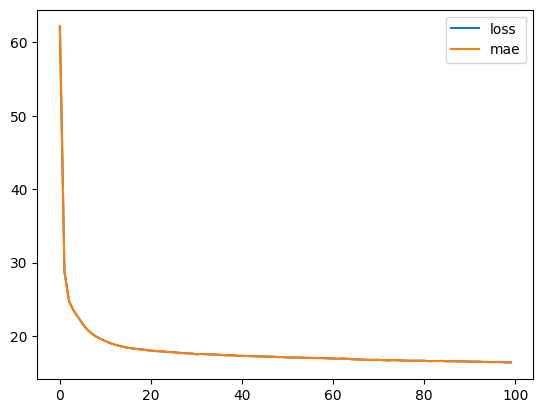

In [ ]:
pd.DataFrame(model1_history.history).plot()

In [ ]:
from sklearn.metrics import r2_score
y_pred = model1.predict(X_test_min_scaled)
r2_score(y_pred, y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.8916902481756893

### lets try by increasing learning rate and by decreasing the epochs

In [ ]:
tf.random.set_seed(42)

## 1. Build the model
model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_min_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

## 2. Compile the model
model2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.01),
    loss = tf.keras.losses.mae,
    metrics = ['mae']
)

## 3. Fit the model with training data
model2_history = model2.fit(X_train_min_scaled, y_train, epochs = 50, batch_size = 16)

Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 54.9538 - mae: 54.9538
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 26.7243 - mae: 26.7243
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 25.6201 - mae: 25.6201
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 25.2591 - mae: 25.2591
Epoch 5/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.9727 - mae: 24.9727
Epoch 6/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.5019 - mae: 24.5019
Epoch 7/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 24.0243 - mae: 24.0243
Epoch 8/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23.5708 - mae: 23.5708
Epoch 9/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 23.1914 - mae: 23.1914
Epoch 10/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.3101 - mae: 21.3101
Epoch 11/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.5131 - mae: 20.5131
Epoch 12/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 

<Axes: >

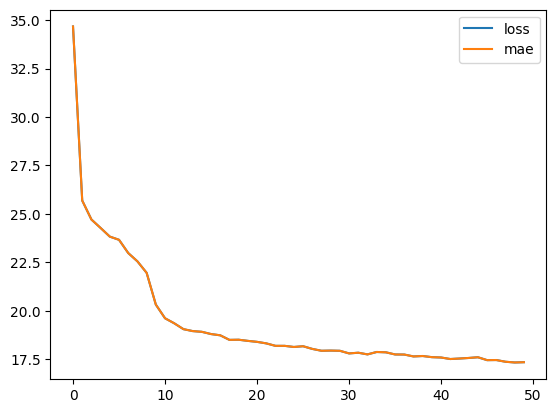

In [ ]:
pd.DataFrame(model2_history.history).plot()

In [ ]:
y_pred = model2.predict(X_test_min_scaled)
r2_score(y_pred, y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.8953857410170896

### lets try by increasing lr to 0.1

In [ ]:
tf.random.set_seed(42)

## 1. Build the model
model3 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_min_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

## 2. Compile the model
model3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1),
    loss = tf.keras.losses.mae,
    metrics = ['mae']
)

## 3. Fit the model with training data
model3_history = model3.fit(X_train_min_scaled, y_train, epochs = 50, batch_size = 16)

Epoch 1/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 42.0718 - mae: 42.0718
Epoch 2/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 30.2159 - mae: 30.2159
Epoch 3/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 25.1565 - mae: 25.1565
Epoch 4/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 22.8062 - mae: 22.8062
Epoch 5/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21.8315 - mae: 21.8315
Epoch 6/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 20.8490 - mae: 20.8490
Epoch 7/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 21.0657 - mae: 21.0657
Epoch 8/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 20.7830 - mae: 20.7830
Epoch 9/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.6661 - mae: 20.6661
Epoch 10/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.5155 - mae: 20.5155
Epoch 11/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 20.5157 - mae: 20.5157
Epoch 12/50
1041/1041 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 

<Axes: >

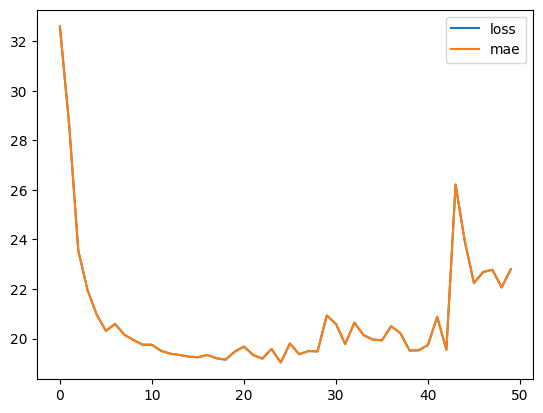

In [ ]:
pd.DataFrame(model3_history.history).plot()

In [ ]:
y_pred = model3.predict(X_test_min_scaled)
r2_score(y_pred, y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


0.8838863584342922

### Since Our loss is very low at 15 to 20 epochs we will add callbacks for early stopping and by increasing batch size as 32 it will model to fit faster

In [ ]:
tf.random.set_seed(42)

## 1. Build the model
model4 = tf.keras.Sequential([
    tf.keras.Input(shape=(X_train_min_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(16, activation= 'relu'),
    tf.keras.layers.Dense(1, activation= 'linear'),
])

## 2. Compile the model
model4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.1),
    loss = tf.keras.losses.mae,
    metrics = ['mae']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=5,
    restore_best_weights = True
)
## 3. Fit the model with training data
model4_history = model4.fit(X_train_min_scaled, y_train, epochs = 50, batch_size = 32,  callbacks=[callback])

Epoch 1/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 43.6041 - mae: 43.6041
Epoch 2/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 31.1685 - mae: 31.1685
Epoch 3/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26.2819 - mae: 26.2819
Epoch 4/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.9521 - mae: 23.9521
Epoch 5/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21.7043 - mae: 21.7043
Epoch 6/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21.2479 - mae: 21.2479
Epoch 7/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.9908 - mae: 20.9908
Epoch 8/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.4412 - mae: 20.4412
Epoch 9/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.5678 - mae: 20.5678
Epoch 10/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.7973 - mae: 20.7973
Epoch 11/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 20.3818 - mae: 20.3818
Epoch 12/50
521/521 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 19.9231 - mae: 19.9231
E

<Axes: >

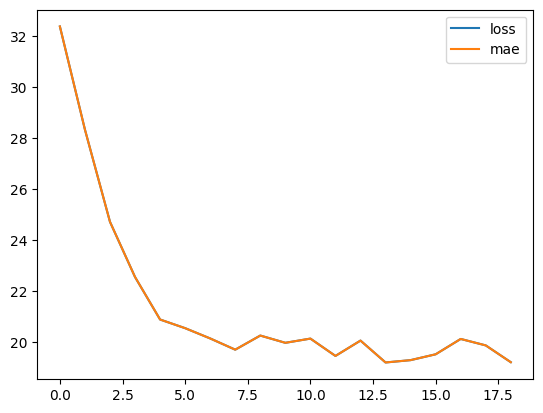

In [ ]:
pd.DataFrame(model4_history.history).plot()

In [ ]:
y_pred = model4.predict(X_test_min_scaled)
r2_score(y_pred, y_test)

257/257 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


0.8935048185295449